In [448]:
import math
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection  import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error, r2_score, mean_absolute_percentage_error
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

# Преобразуем список транзакций в one-hot таблицу
from mlxtend.preprocessing import TransactionEncoder
df = pd.read_csv("TV_Shows.csv")
print("Размер данных")
print(df.shape)
print("Информация")
print(df.info())

Размер данных
(9689, 32)
Информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9689 entries, 0 to 9688
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Cobra Kai    9689 non-null   object
 1   Lupin        7556 non-null   object
 2   12 Monkeys   5946 non-null   object
 3   Sherlock     4666 non-null   object
 4   Unnamed: 4   3678 non-null   object
 5   Unnamed: 5   2837 non-null   object
 6   Unnamed: 6   2197 non-null   object
 7   Unnamed: 7   1664 non-null   object
 8   Unnamed: 8   1231 non-null   object
 9   Unnamed: 9   887 non-null    object
 10  Unnamed: 10  644 non-null    object
 11  Unnamed: 11  464 non-null    object
 12  Unnamed: 12  348 non-null    object
 13  Unnamed: 13  272 non-null    object
 14  Unnamed: 14  196 non-null    object
 15  Unnamed: 15  141 non-null    object
 16  Unnamed: 16  95 non-null     object
 17  Unnamed: 17  66 non-null     object
 18  Unnamed: 18  52 non-null     obj

In [449]:
print("Строки")
print(df.head(5))

Строки
       Cobra Kai          Lupin   12 Monkeys          Sherlock  \
0           Lost      Jack Ryan    The Flash   Game of thrones   
1  Sex Education      Dr. House      Kingdom  The Walking Dead   
2          Ozark  Sex Education  Constantine          Preacher   
3         Naruto            NaN          NaN               NaN   
4  Sex Education            NaN          NaN               NaN   

       Unnamed: 4  Unnamed: 5 Unnamed: 6 Unnamed: 7     Unnamed: 8  \
0  House of Cards  12 Monkeys    Vikings     Fringe  The Mentalist   
1             NaN         NaN        NaN        NaN            NaN   
2         Vikings    The Tick        NaN        NaN            NaN   
3             NaN         NaN        NaN        NaN            NaN   
4             NaN         NaN        NaN        NaN            NaN   

     Unnamed: 9  ... Unnamed: 22 Unnamed: 23 Unnamed: 24 Unnamed: 25  \
0  The Alienist  ...         NaN         NaN         NaN         NaN   
1           NaN  ...         Na

In [450]:
# Подсчёт длины транзакции (кол-во непустых значений в строке)
transaction_lengths = df.notna().sum(axis=1)

# Добавим этот столбец в датафрейм (для наглядности)
df['transaction_length'] = transaction_lengths

# Посмотрим базовую статистику
print(transaction_lengths.describe())

count    9689.000000
mean        4.414078
std         3.597709
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        32.000000
dtype: float64


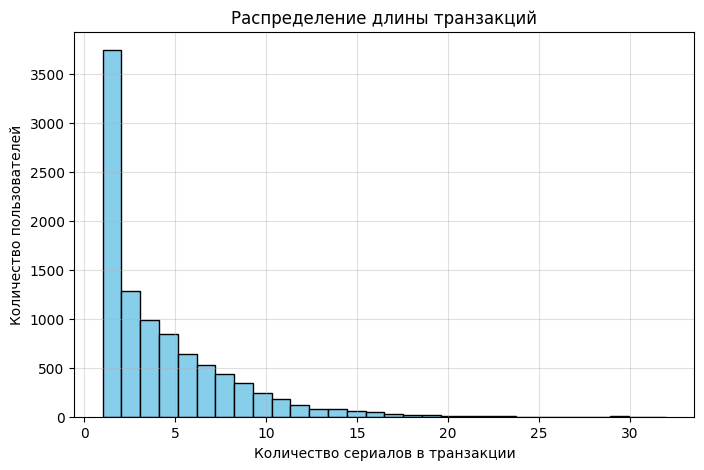

In [451]:
plt.figure(figsize=(8,5))
plt.hist(transaction_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение длины транзакций')
plt.xlabel('Количество сериалов в транзакции')
plt.ylabel('Количество пользователей')
plt.grid(alpha=0.4)
plt.show()

In [452]:
# Объединяем все значения в один Series и убираем NaN
all_items = pd.Series(df.drop(columns='transaction_length').values.ravel()).dropna()

# Преобразуем в множество уникальных сериалов
unique_items = sorted(all_items.unique())

print(f"Всего уникальных сериалов: {len(unique_items)}")
print(unique_items[:30])  # покажем первые 30 названий

Всего уникальных сериалов: 156
['12 Monkeys', '24', 'Absentia', 'Alice in Borderland', 'Altered Carbon', 'American Gods', 'Another Life', 'Archer', 'Arrow', 'Atypical', 'Banshee', 'Berlin Station', 'Better Call Saul', 'Big Little Lies', 'Billions', 'Black Clover', 'Bojack Horseman', 'Breaking Bad', 'Brooklyn Nine Nine', 'Chernobyl', 'Cobra Kai', 'Constantine', 'Daredevil', 'Dark', 'Death Note', 'Deception', 'Demon Slayer', 'Designated Survivor', 'Dexter', 'Doctor Who']


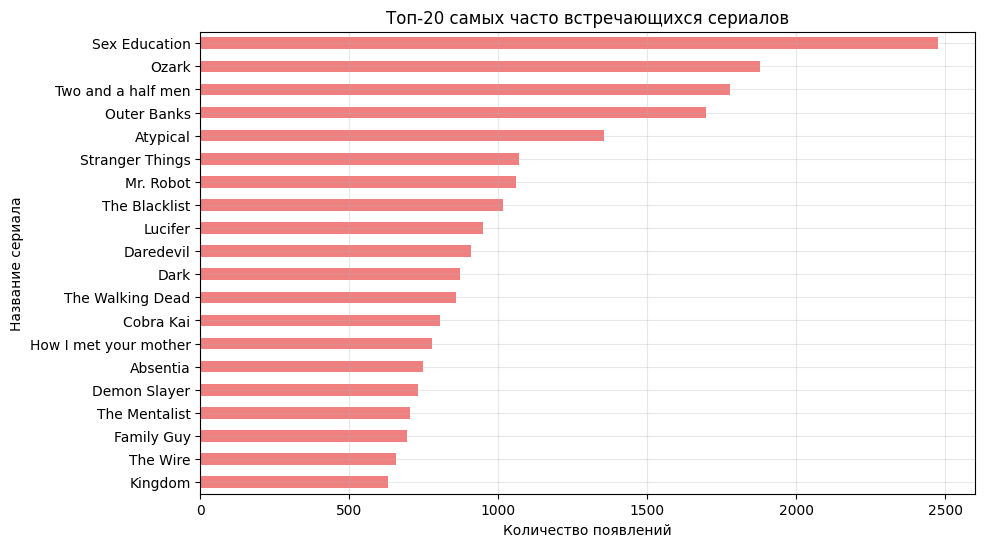

In [453]:
top_items = all_items.value_counts().head(20)

plt.figure(figsize=(10,6))
top_items.plot(kind='barh', color='lightcoral')
plt.title('Топ-20 самых часто встречающихся сериалов')
plt.xlabel('Количество появлений')
plt.ylabel('Название сериала')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.show()

In [454]:
print("Пропущенные значения по столбцам:")
print(df.isna().sum())

Пропущенные значения по столбцам:
Cobra Kai                0
Lupin                 2133
12 Monkeys            3743
Sherlock              5023
Unnamed: 4            6011
Unnamed: 5            6852
Unnamed: 6            7492
Unnamed: 7            8025
Unnamed: 8            8458
Unnamed: 9            8802
Unnamed: 10           9045
Unnamed: 11           9225
Unnamed: 12           9341
Unnamed: 13           9417
Unnamed: 14           9493
Unnamed: 15           9548
Unnamed: 16           9594
Unnamed: 17           9623
Unnamed: 18           9637
Unnamed: 19           9651
Unnamed: 20           9660
Unnamed: 21           9671
Unnamed: 22           9675
Unnamed: 23           9681
Unnamed: 24           9682
Unnamed: 25           9682
Unnamed: 26           9683
Unnamed: 27           9684
Unnamed: 28           9685
Unnamed: 29           9688
Unnamed: 30           9688
Unnamed: 31           9688
transaction_length       0
dtype: int64


In [455]:
transactions = []
for i in range(len(df)):
    row = df.iloc[i, :-1].dropna().tolist()  # исключаем NaN и transaction_length
    transactions.append(row)
# Быстрая проверка
print("Первые 5 транзакций:", transactions[:5])
print("Число транзакций:", len(transactions))



Первые 5 транзакций: [['Lost', 'Jack Ryan', 'The Flash', 'Game of thrones', 'House of Cards', '12 Monkeys', 'Vikings', 'Fringe', 'The Mentalist', 'The Alienist', 'Big Little Lies', 'Chernobyl'], ['Sex Education', 'Dr. House', 'Kingdom', 'The Walking Dead'], ['Ozark', 'Sex Education', 'Constantine', 'Preacher', 'Vikings', 'The Tick'], ['Naruto'], ['Sex Education']]
Число транзакций: 9689


In [ ]:
#3
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df_trans, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules_sorted = rules.sort_values(by='lift', ascending=False).reset_index(drop=True)
#полученные результаты, выделяются полезными или тривиальными
def label_rule(row):
    if row['lift'] >= 1.2 and row['confidence'] >= 0.5 and row['support'] >= 0.01:
        return 'useful'
    if 0.95 <= row['lift'] <= 1.1:
        return 'trivial'
    if row['confidence'] < 0.4:
        return 'weak'
    return 'need_review'

rules_sorted['label'] = rules_sorted.apply(label_rule, axis=1)
print("Apriori выявил только одно правило: (Ozark, Atypical) -> Sex Education, то есть")
print("если пользователь смотрит Ozark и Atypical. то с вероятностбю 51% он еще смотрит Sex Education.")
print("Лифт = 2.0 показывает, что связь в два раза сильнее случайной")


print(rules_sorted['label'].value_counts())
rules_sorted[['antecedents','consequents','support','confidence','lift','label']].head(30)



Apriori выявил только одно правило: (Ozark, Atypical) -> Sex Education, то есть
если пользователь смотрит Ozark и Atypical. то с вероятностбю 51% он еще смотрит Sex Education.
Лифт = 2.0 показывает, что связь в два раза сильнее случайной
label
useful    1
Name: count, dtype: int64


,antecedents,consequents,support,confidence,lift,label
0,"(Ozark, Atypical)",(Sex Education),0.022397,0.511792,2.00192,useful


In [ ]:
#3
support_list = [0.01, 0.02, 0.03]
confidence_list = [0.4, 0.5, 0.6]

experiment_results = []

import itertools
for minsup, minconf in itertools.product(support_list, confidence_list):
    fi = apriori(df_trans, min_support=minsup, use_colnames=True)
    rs = association_rules(fi, metric="confidence", min_threshold=minconf)
    n_rules = len(rs)
    mean_lift = rs['lift'].mean() if n_rules>0 else None
    experiment_results.append({
        'minsup': minsup,
        'minconf': minconf,
        'n_itemsets': len(fi),
        'n_rules': n_rules,
        'mean_lift': round(mean_lift,3) if mean_lift else None
    })

exp_df = pd.DataFrame(experiment_results).sort_values(['minsup','minconf'])
print("\nВлияние параметров на количество правил и лифт:")
print(exp_df)
print("При снижении минимальной поддержки (minsup) алгоритм находит больше частых наборов и правил.")
print("При повышении минимальной достоверности (minconf) количество правил резко падает,")
print("так как многие правила оказываются недостаточно надежными.")
print("Средний лифт растет с ростом minconf, чем выше confidence, тем сильнее связь между элементами.")
print("Таким образом, для нашего набора данных разумные пороги: min_support = 0.01–0.02, min_confidence = 0.4–0.5.")


Влияние параметров на количество правил и лифт:
   minsup  minconf  n_itemsets  n_rules  mean_lift
0    0.01      0.4         347       62      2.006
1    0.01      0.5         347       16      2.299
2    0.01      0.6         347        0        NaN
3    0.02      0.4         125       16      1.845
4    0.02      0.5         125        1      2.002
5    0.02      0.6         125        0        NaN
6    0.03      0.4          66        6      1.794
7    0.03      0.5          66        0        NaN
8    0.03      0.6          66        0        NaN
При снижении минимальной поддержки (minsup) алгоритм находит больше частых наборов и правил.
При повышении минимальной достоверности (minconf) количество правил резко падает,
так как многие правила оказываются недостаточно надежными.
Средний лифт растет с ростом minconf, чем выше confidence, тем сильнее связь между элементами.
Таким образом, для нашего набора данных разумные пороги: min_support = 0.01–0.02, min_confidence = 0.4–0.5.


In [460]:
# 4. Алгоритм FPG
print("Алгоритм FPGrowth нашёл точно такое же правило, как Apriori.")
print("Правило: если пользователь смотрит Ozark и Atypical, вероятность, что он смотрит Sex Education — 51%, лифт = 2.0.")
print("")
frequent_itemsets_fpg = fpgrowth(df_trans, min_support=0.02, use_colnames=True)
print("Частые наборы, найденные FPG:", frequent_itemsets_fpg.shape[0])

#Классификация правил (полезные, тривиальные, слабые)
min_confidence = 0.5
rules_fpg = association_rules(frequent_itemsets_fpg, metric="confidence", min_threshold=min_confidence)
print("Число правил FPG:", len(rules_fpg))

rules_fpg['label'] = rules_fpg.apply(label_rule, axis=1)

#вывод первых 20 правил
rules_fpg[['antecedents','consequents','support','confidence','lift','label']].head(20)



Алгоритм FPGrowth нашёл точно такое же правило, как Apriori.
Правило: если пользователь смотрит Ozark и Atypical, вероятность, что он смотрит Sex Education — 51%, лифт = 2.0.

Частые наборы, найденные FPG: 125
Число правил FPG: 1


,antecedents,consequents,support,confidence,lift,label
0,"(Ozark, Atypical)",(Sex Education),0.022397,0.511792,2.00192,useful


In [461]:
#5. Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.
max_length = 5  
step = 0.01
min_support_start = 0.1
min_support_end = 0.01

min_support_per_length = {}

for length in range(1, max_length+1):
    support = min_support_start
    found = False
    while support >= min_support_end:
        fi = apriori(df_trans, min_support=support, use_colnames=True)
        fi_length = fi[fi['itemsets'].apply(lambda x: len(x) == length)]
        if not fi_length.empty:
            min_support_per_length[length] = support
            found = True
            break
        support -= step
    if not found:
        min_support_per_length[length] = None

print("Минимальная поддержка для наборов разной длины:")
for length, sup in min_support_per_length.items():
    print(f"{length} объектов: min_support = {sup}")

print("Чем больше элементов в наборе, тем реже они встречаюся в транзакциях, и тем ниже должна быть поддержка, чтобы найти хотя бы одно правило.")
print("Это показывает ограниченность данных для длинных комбинаций сериалов")

Минимальная поддержка для наборов разной длины:
1 объектов: min_support = 0.1
2 объектов: min_support = 0.07000000000000002
3 объектов: min_support = 0.02000000000000001
4 объектов: min_support = None
5 объектов: min_support = None
Чем больше элементов в наборе, тем реже они встречаюся в транзакциях, и тем ниже должна быть поддержка, чтобы найти хотя бы одно правило.
Это показывает ограниченность данных для длинных комбинаций сериалов


In [ ]:
#6
support_list = [0.05, 0.03, 0.02, 0.01]  
confidence_list = [0.4, 0.5, 0.6, 0.7]

print(f"support_list = {support_list}")
print(f"confidence_list = {confidence_list}")
print()
print("При уменьшении минимальной поддержки (min_support) алгоритм начинает находить больше правил,")
print("так как в анализ включаются более редкие сочетания товаров/сериалов.")
print()
print("При увеличении минимальной достоверности (min_confidence) количество правил уменьшается.")
print("при min_confidence = 0.4 для min_support = 0.01 получено 62 правила,")
print("а при min_confidence = 0.6 при правил уже нет.")
print()

experiment_results = []

for minsup, minconf in itertools.product(support_list, confidence_list):
    fi = apriori(df_trans, min_support=minsup, use_colnames=True)
    if fi.empty:
        experiment_results.append({
            'minsup': minsup,
            'minconf': minconf,
            'n_itemsets': len(fi),
            'n_rules': 0,
            'mean_lift': None,
            'mean_confidence': None,
            'n_useful': 0,
            'n_trivial': 0
        })
        continue

    rs = association_rules(fi, metric="confidence", min_threshold=minconf)
    n_rules = len(rs)
    mean_lift = rs['lift'].mean() if n_rules>0 else None
    mean_conf = rs['confidence'].mean() if n_rules>0 else None

    # метки
    if n_rules > 0:
        rs['label'] = rs.apply(label_rule, axis=1)
        n_useful = (rs['label']=='useful').sum()
        n_trivial = (rs['label']=='trivial').sum()
    else:
        n_useful = 0
        n_trivial = 0

    experiment_results.append({
        'minsup': minsup,
        'minconf': minconf,
        'n_itemsets': len(fi),
        'n_rules': n_rules,
        'mean_lift': mean_lift,
        'mean_confidence': mean_conf,
        'n_useful': n_useful,
        'n_trivial': n_trivial
    })

exp_df = pd.DataFrame(experiment_results)
print(exp_df.sort_values(['minsup','minconf'], ascending=[True,True]))



support_list = [0.05, 0.03, 0.02, 0.01]
confidence_list = [0.4, 0.5, 0.6, 0.7]

При уменьшении минимальной поддержки (min_support) алгоритм начинает находить больше правил,
так как в анализ включаются более редкие сочетания товаров/сериалов.

При увеличении минимальной достоверности (min_confidence) количество правил уменьшается.
при min_confidence = 0.4 для min_support = 0.01 получено 62 правила,
а при min_confidence = 0.6 при правил уже нет.

    minsup  minconf  n_itemsets  n_rules  mean_lift  mean_confidence  \
12    0.01      0.4         347       62   2.005840         0.467738   
13    0.01      0.5         347       16   2.298567         0.543946   
14    0.01      0.6         347        0        NaN              NaN   
15    0.01      0.7         347        0        NaN              NaN   
8     0.02      0.4         125       16   1.844539         0.445298   
9     0.02      0.5         125        1   2.001920         0.511792   
10    0.02      0.6         125        0       

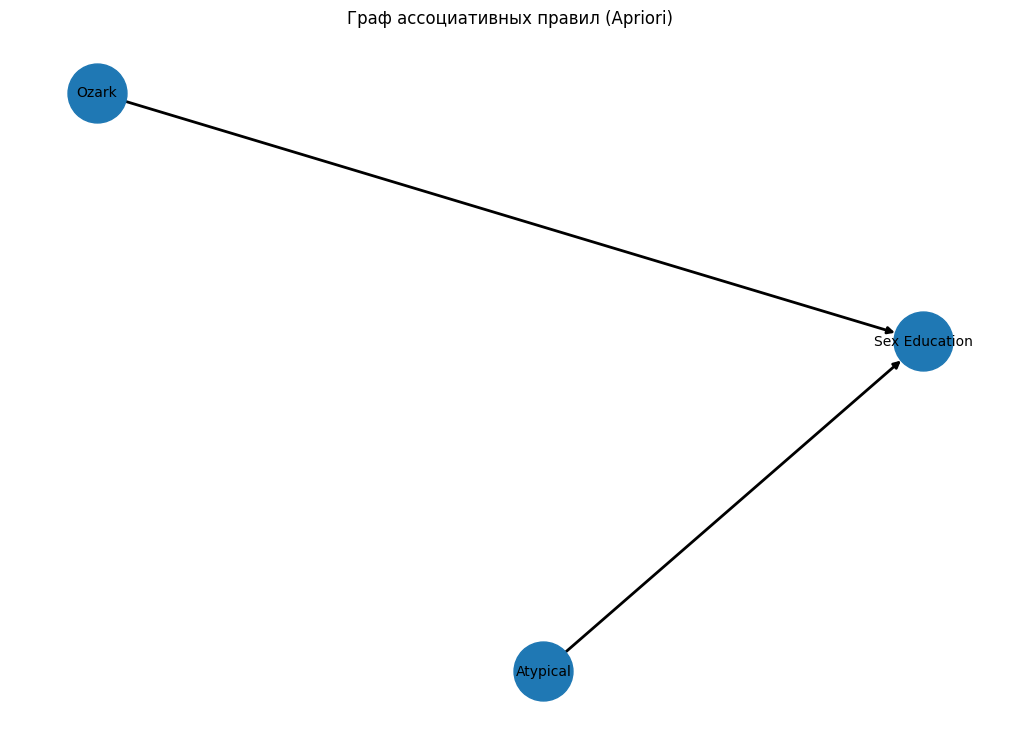

По графу можно увидеть, что Atypical и Ozark направлены к Sex Education, что означает:
если пользователь смотрит один из этих сериалов, у него повышается вероятность также посмотреть Sex Education


In [463]:
#7
G = nx.DiGraph()

for _, row in rules_sorted.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(a, c, weight=row['lift'])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5)

nx.draw(G, pos, with_labels=True, node_size=1800, font_size=10, width=2)
plt.title("Граф ассоциативных правил (Apriori)")
plt.show()

print("По графу можно увидеть, что Atypical и Ozark направлены к Sex Education, что означает:")
print("если пользователь смотрит один из этих сериалов, у него повышается вероятность также посмотреть Sex Education")

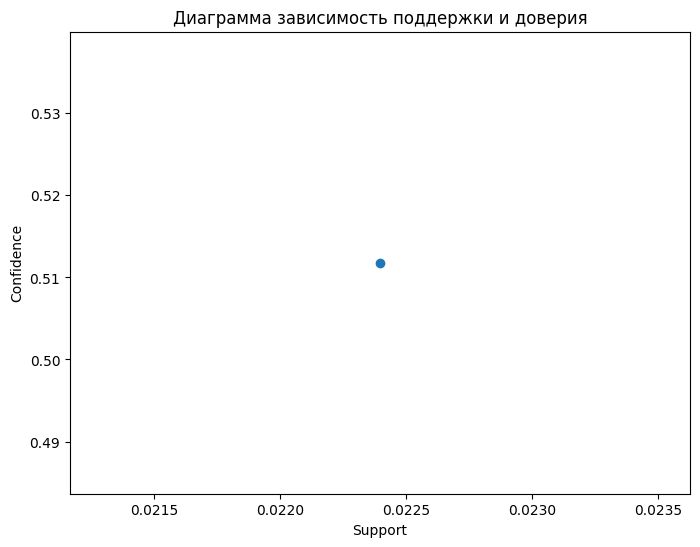

На диаграмме отображена только одна точка, т.к. по параметрам minsupport и minconfidence было найдено только одно ассоциативное правило
Правило имеет поддержку ~2.2% и достоверность ~51%


In [464]:
plt.figure(figsize=(8,6))
plt.scatter(rules_sorted['support'], rules_sorted['confidence'])
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Диаграмма зависимость поддержки и доверия")
plt.show()

print("На диаграмме отображена только одна точка, т.к. по параметрам minsupport и minconfidence было найдено только одно ассоциативное правило")
print("Правило имеет поддержку ~2.2% и достоверность ~51%")